## Terrorism Hotspots

Imagine you are a security or defense analyst. Analyze the data and draw conclusions on the distribution and nature of terrorist incidents recorded around the world. In your analysis, include maps that visualize the location of different incidents. Your analysis may also provide answers to the following questions:

- How has the number of terrorist activities changed over the years?
- Are there certain regions where this trend is different from the global averages?
- Is the number of incidents and the number of casualties correlated?
- Can you spot any irregularities or outliers?
- What are the most common methods of attacks? Does it differ in various regions or in time?
- Plot the locations of attacks on a map to visualize their regional spread;
You are also free to explore the data further and extract additional insights other than the questions above.

## Data Description

The provided compressed file globalterrorismdb_0718dist.tar.bz2 is an extract from the Global Terrorism Database (GTD) - an open-source database including information on terrorist attacks around the world from 1970 through 2017. The GTD includes systematic data on domestic as well as international terrorist incidents that have occurred during this time period and now includes more than 180,000 attacks. The database is maintained by researchers at the National Consortium for the Study of Terrorism and Responses to Terrorism (START), headquartered at the University of Maryland.

Since the number of variables and instances is very large, for this project, feel free to select a subset of columns or a specific timeframe.

Explanation of selected columns:

- success - Success of a terrorist strike
- suicide - 1 = "Yes" The incident was a suicide attack. 0 = "No" There is no indication that the incident was a suicide
- attacktype1 - The general method of attack
- attacktype1_txt - The general method of attack and broad class of tactics used.
- targtype1_txt - The general type of target/victim
- targsubtype1_txt - The more specific target category
- target1 - The specific person, building, installation that was targeted and/or victimized
- natlty1_txt - The nationality of the target that was attacked
- gname - The name of the group that carried out the attack
- gsubname - Additional details about group that carried out the attack like fractions
- nperps - The total number of terrorists participating in the incident
- weaptype1_txt - General type of weapon used in the incident
- weapsubtype1_txt - More specific value for most of the Weapon Types
- nkill - The number of total confirmed fatalities for the incident
- nkillus - The number of U.S. citizens who died as a result of the incident

## Add Libraries and some helpful functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster


def column_distribution(df, field_name="Outcome"):

    existing_fields = df.columns

    if type(field_name) != list and field_name in existing_fields:
        dist = df[field_name].value_counts(dropna=False).reset_index(name="Count")
        field_name = [field_name]
    else:
        field_name = [field for field in field_name if field in existing_fields]
        dist = df[field_name].fillna("NaN").value_counts().reset_index(name="Count")
    dist["Freq %"] = round(dist["Count"] / (dist["Count"].sum()) * 100, 3).map(
        "{:,.2f}%".format
    )
    dist["Count"] = dist["Count"].map("{:,.0f}".format)
    dist.columns = field_name + ["Count", "Freq %"]
    return dist

def get_firing_rates(df):
    def highlight_null(v, props=""):
        return np.where(v.values != "0.00%", props, "")

    for col in df:
        df[col] = np.where(pd.isnull(df[col]), df[col], df[col].astype(str))

    fire_rates = df.describe().T
    fire_rates["Unique %"] = (fire_rates["unique"] / df.shape[0] * 100).map(
        "{:,.2f}%".format
    )
    fire_rates["Fire Rate %"] = (fire_rates["count"] / df.shape[0] * 100).map(
        "{:,.2f}%".format
    )
    fire_rates["Null Rate %"] = ((1 - (fire_rates["count"] / df.shape[0])) * 100).map(
        "{:,.2f}%".format
    )
    fire_rates["count"] = fire_rates["count"].map("{:,.0f}".format)
    fire_rates["unique"] = fire_rates["unique"].map("{:,.0f}".format)
    fire_rates["freq"] = fire_rates["freq"].map("{:,.0f}".format)
    fire_rates = fire_rates.rename(
        columns={
            "count": "Count",
            "unique": "Unique",
            "top": "Most Common Value",
            "freq": "Freq",
            "unique %": "Unique %",
        }
    )
    fire_rates_styled = fire_rates.style.apply(
        highlight_null,
        props="color:red; background-color:#ffffb3",
        subset=["Null Rate %"],
        axis=0,
    )
    display(fire_rates_styled)



### Read the data

In [2]:
df = pd.read_csv("globalterrorismdb_0718dist.tar.bz2", compression="bz2")

/var/folders/_v/1y0dkvbs7qv0_gm0z522h9z80000gn/T/ipykernel_12039/1691415715.py:1: DtypeWarning: Columns (5,7,32,34,62,63,64,77,80,91,93,95,97,115,116,122) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("globalterrorismdb_0718dist.tar.bz2", compression="bz2")


In [3]:
df.head()

,Unnamed: 0,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


### Get insights of each column

In [4]:
get_firing_rates(df)

,Count,Unique,Most Common Value,Freq,Unique %,Fire Rate %,Null Rate %
Unnamed: 0,"181,691","181,691",0,1,100.00%,100.00%,0.00%
eventid,"181,691","181,691",197000000001,1,100.00%,100.00%,0.00%
iyear,"181,691",47,2014,"16,903",0.03%,100.00%,0.00%
imonth,"181,691",13,5,"16,875",0.01%,100.00%,0.00%
iday,"181,691",32,15,"6,500",0.02%,100.00%,0.00%
approxdate,"9,239","2,244","September 18-24, 2016",101,1.24%,5.09%,94.91%
extended,"181,691",2,0,"173,452",0.00%,100.00%,0.00%
resolution,"2,220","1,859",8/4/1998,18,1.02%,1.22%,98.78%
country,"181,691",205,95,"24,636",0.11%,100.00%,0.00%
country_txt,"181,691",205,Iraq,"24,636",0.11%,100.00%,0.00%


In [6]:
def get_firing_rates(df):
    def highlight_null(v, props=""):
        return np.where(v.values != "0.00%", props, "")

    for col in df:
        df[col] = np.where(pd.isnull(df[col]), df[col], df[col].astype(str))

    fire_rates = df.describe().T
    fire_rates["Unique %"] = (fire_rates["unique"] / df.shape[0] * 100).map(
        "{:,.2f}%".format
    )
    fire_rates["Fire Rate %"] = (fire_rates["count"] / df.shape[0] * 100).map(
        "{:,.2f}%".format
    )
    fire_rates["Null Rate %"] = ((1 - (fire_rates["count"] / df.shape[0])) * 100).map(
        "{:,.2f}%".format
    )
    fire_rates["count"] = fire_rates["count"].map("{:,.0f}".format)
    fire_rates["unique"] = fire_rates["unique"].map("{:,.0f}".format)
    fire_rates["freq"] = fire_rates["freq"].map("{:,.0f}".format)
    fire_rates = fire_rates.rename(
        columns={
            "count": "Count",
            "unique": "Unique",
            "top": "Most Common Value",
            "freq": "Freq",
            "unique %": "Unique %",
        }
    )
    return fire_rates
result_df=get_firing_rates(df)
df1=result_df[result_df['Null Rate %'].str.replace('%','').astype(float)<=0.05]
df1.index

Index(['Unnamed: 0', 'eventid', 'iyear', 'imonth', 'iday', 'extended',
       'country', 'country_txt', 'region', 'region_txt', 'specificity',
       'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple',
       'success', 'suicide', 'attacktype1', 'attacktype1_txt', 'targtype1',
       'targtype1_txt', 'gname', 'individual', 'weaptype1', 'weaptype1_txt',
       'property', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'],
      dtype='object')

### Keep only the columns with less than 5% null values

In [7]:
df = pd.read_csv("globalterrorismdb_0718dist.tar.bz2", compression="bz2")
df=df[['eventid', 'iyear', 'imonth', 'iday', 'extended',
       'country', 'country_txt', 'region', 'region_txt', 'specificity',
       'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple',
       'success', 'suicide', 'attacktype1', 'attacktype1_txt', 'targtype1',
       'targtype1_txt', 'gname', 'individual', 'weaptype1', 'weaptype1_txt',
       'property', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY','longitude','latitude']]

/var/folders/_v/1y0dkvbs7qv0_gm0z522h9z80000gn/T/ipykernel_12039/3935328065.py:1: DtypeWarning: Columns (5,7,32,34,62,63,64,77,80,91,93,95,97,115,116,122) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("globalterrorismdb_0718dist.tar.bz2", compression="bz2")


### How has the number of terrorist activities changed over the years?

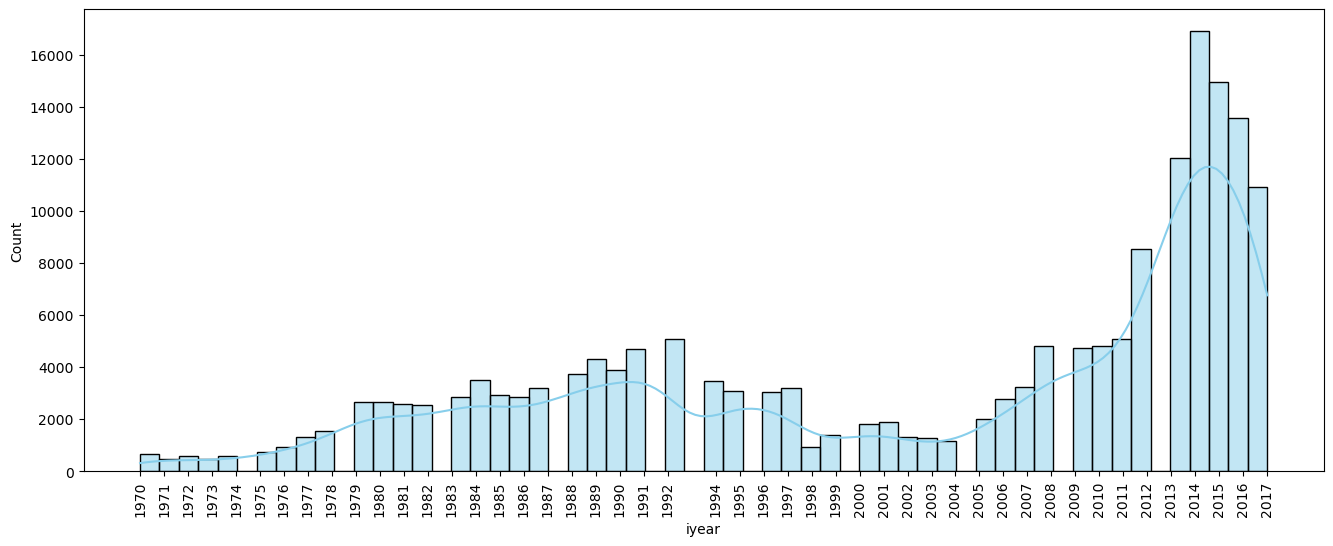

In [8]:
plt.figure(figsize=(16, 6)) 
sns.histplot(df['iyear'],kde=True, color='skyblue')
plt.xticks([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1986, 1982, 1983, 1984, 1985, 1987, 1988, 1989, 1990, 1991,
       1992, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017],rotation=90)
plt.show()

###  Are there certain regions where this trend is different from the global averages?

In [9]:
column_distribution(df,'country_txt')

,country_txt,Count,Freq %
0,Iraq,"24,636",13.56%
1,Pakistan,"14,368",7.91%
2,Afghanistan,"12,731",7.01%
3,India,"11,960",6.58%
4,Colombia,"8,306",4.57%
...,...,...,...
200,International,1,0.00%
201,Wallis and Futuna,1,0.00%
202,South Vietnam,1,0.00%
203,Andorra,1,0.00%


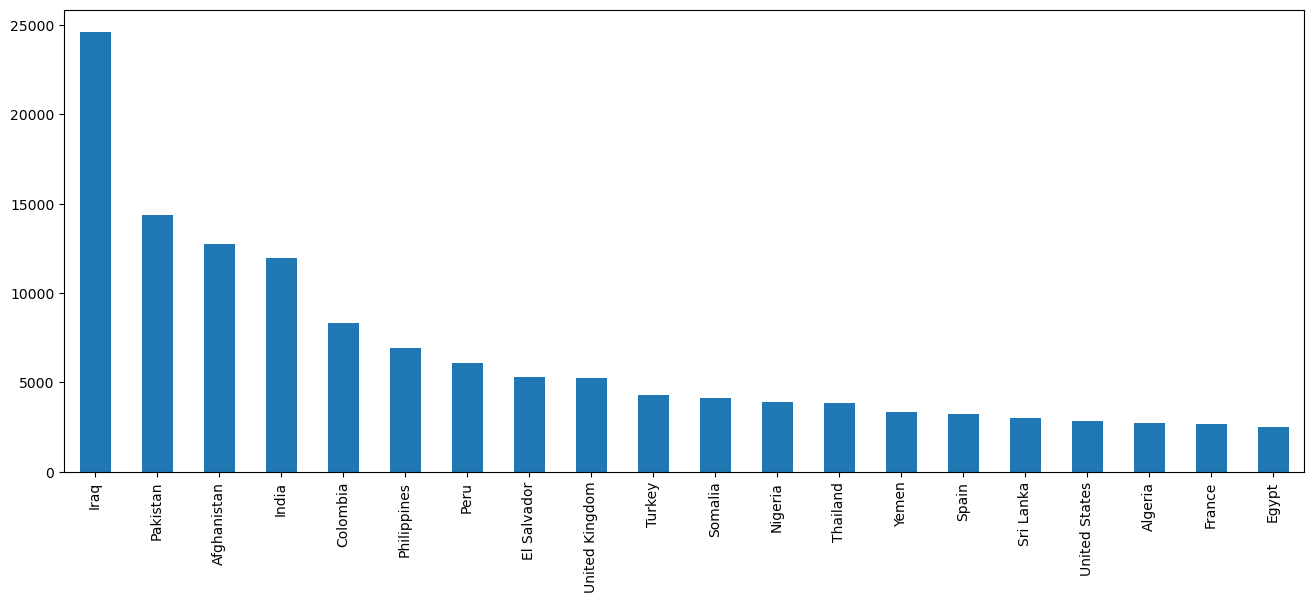

In [10]:
plt.figure(figsize=(16, 6)) 
df['country_txt'].value_counts()[:20].plot.bar()
plt.show()

In [11]:
column_distribution(df, 'region_txt')

,region_txt,Count,Freq %
0,Middle East & North Africa,"50,474",27.78%
1,South Asia,"44,974",24.75%
2,South America,"18,978",10.45%
3,Sub-Saharan Africa,"17,550",9.66%
4,Western Europe,"16,639",9.16%
5,Southeast Asia,"12,485",6.87%
6,Central America & Caribbean,"10,344",5.69%
7,Eastern Europe,"5,144",2.83%
8,North America,"3,456",1.90%
9,East Asia,802,0.44%


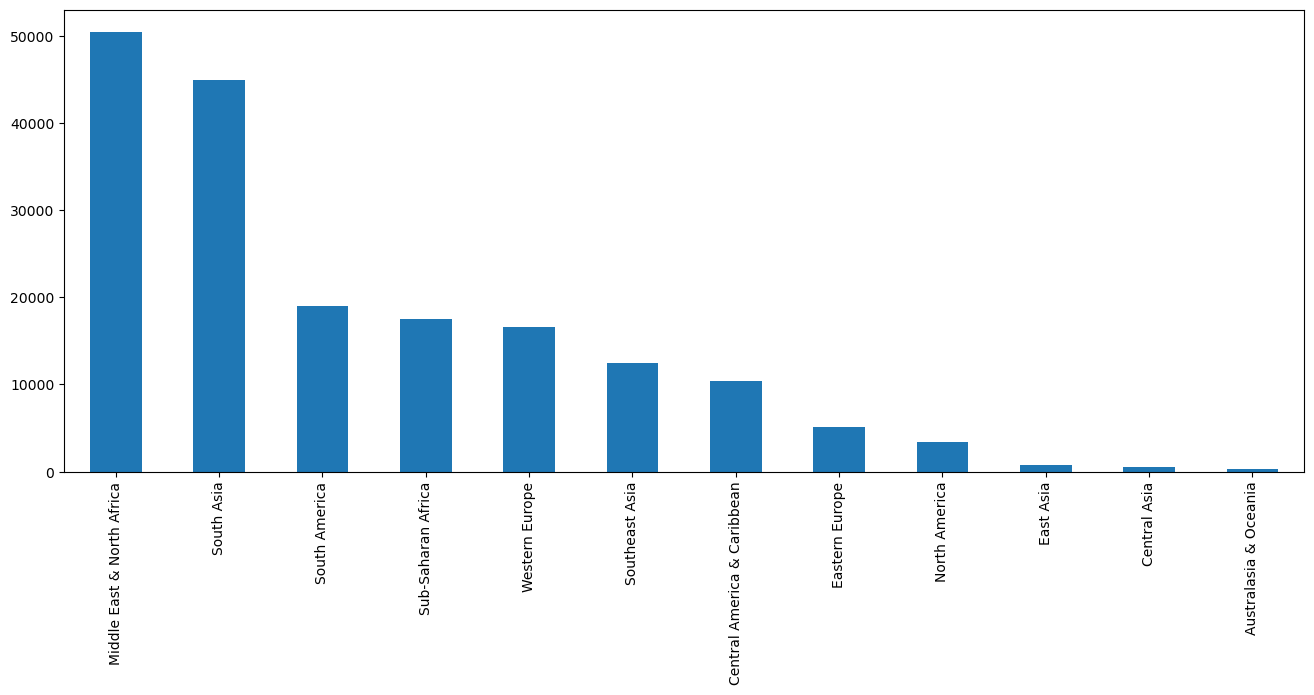

In [12]:
plt.figure(figsize=(16, 6)) 
df['region_txt'].value_counts()[:20].plot.bar()
plt.show()

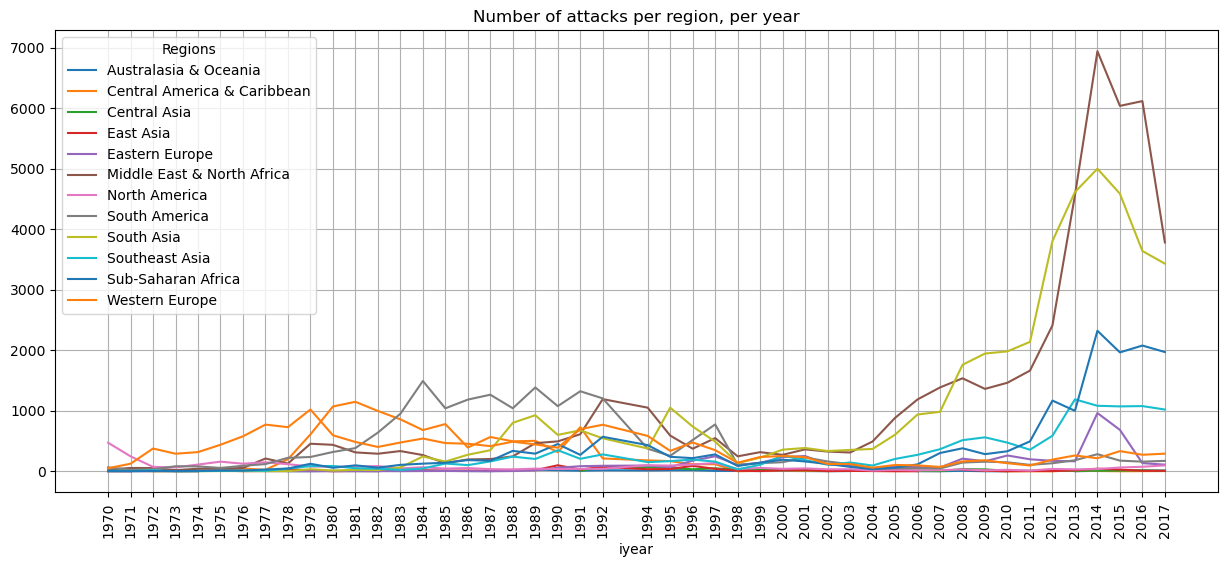

In [13]:
df1 = df.groupby(['region_txt', 'iyear']).agg({'eventid':'count'})

df1.unstack(level=0)['eventid'].plot(kind='line', figsize=(15, 6), grid=True)
plt.legend(title='Regions')
plt.title('Number of attacks per region, per year')
plt.xticks([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1986, 1982, 1983, 1984, 1985, 1987, 1988, 1989, 1990, 1991,
       1992, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017],rotation=90)
plt.show()

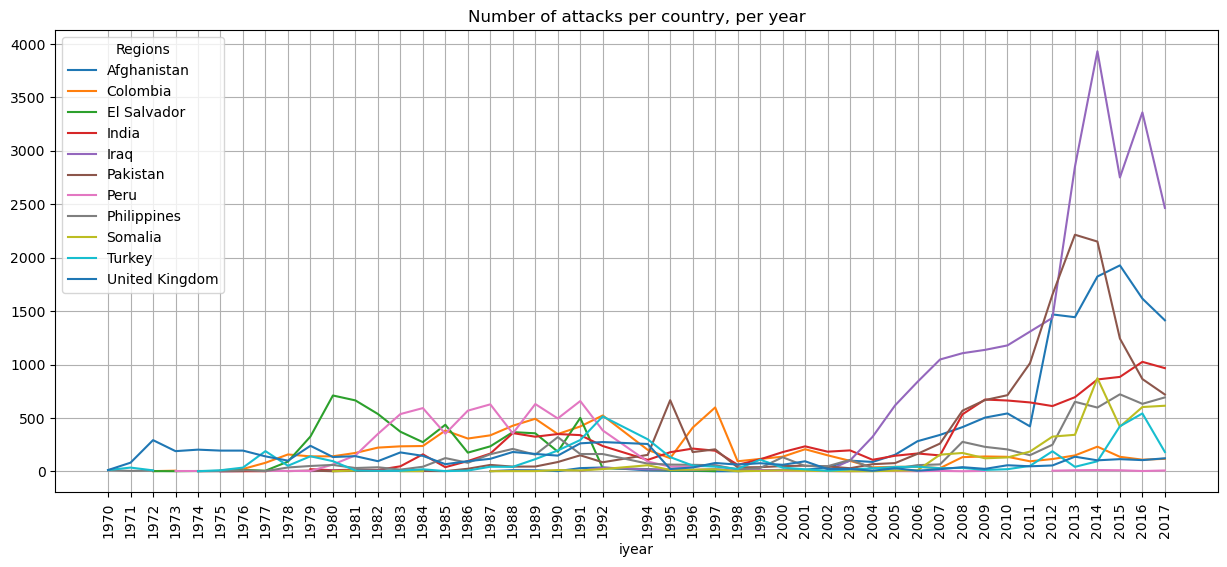

In [14]:
df1=df[df.country_txt.isin(['Iraq',
 'Pakistan',
 'Afghanistan',
 'India',
 'Colombia',
 'Philippines',
 'Peru',
 'El Salvador',
 'United Kingdom',
 'Turkey',
 'Somalia'])]
df1 = df1.groupby(['country_txt', 'iyear']).agg({'eventid':'count'})

df1.unstack(level=0)['eventid'].plot(kind='line', figsize=(15, 6), grid=True)
plt.legend(title='Regions')
plt.title('Number of attacks per country, per year')
plt.xticks([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1986, 1982, 1983, 1984, 1985, 1987, 1988, 1989, 1990, 1991,
       1992, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017],rotation=90)
plt.show()

## Is the number of incidents and the number of casualties correlated?

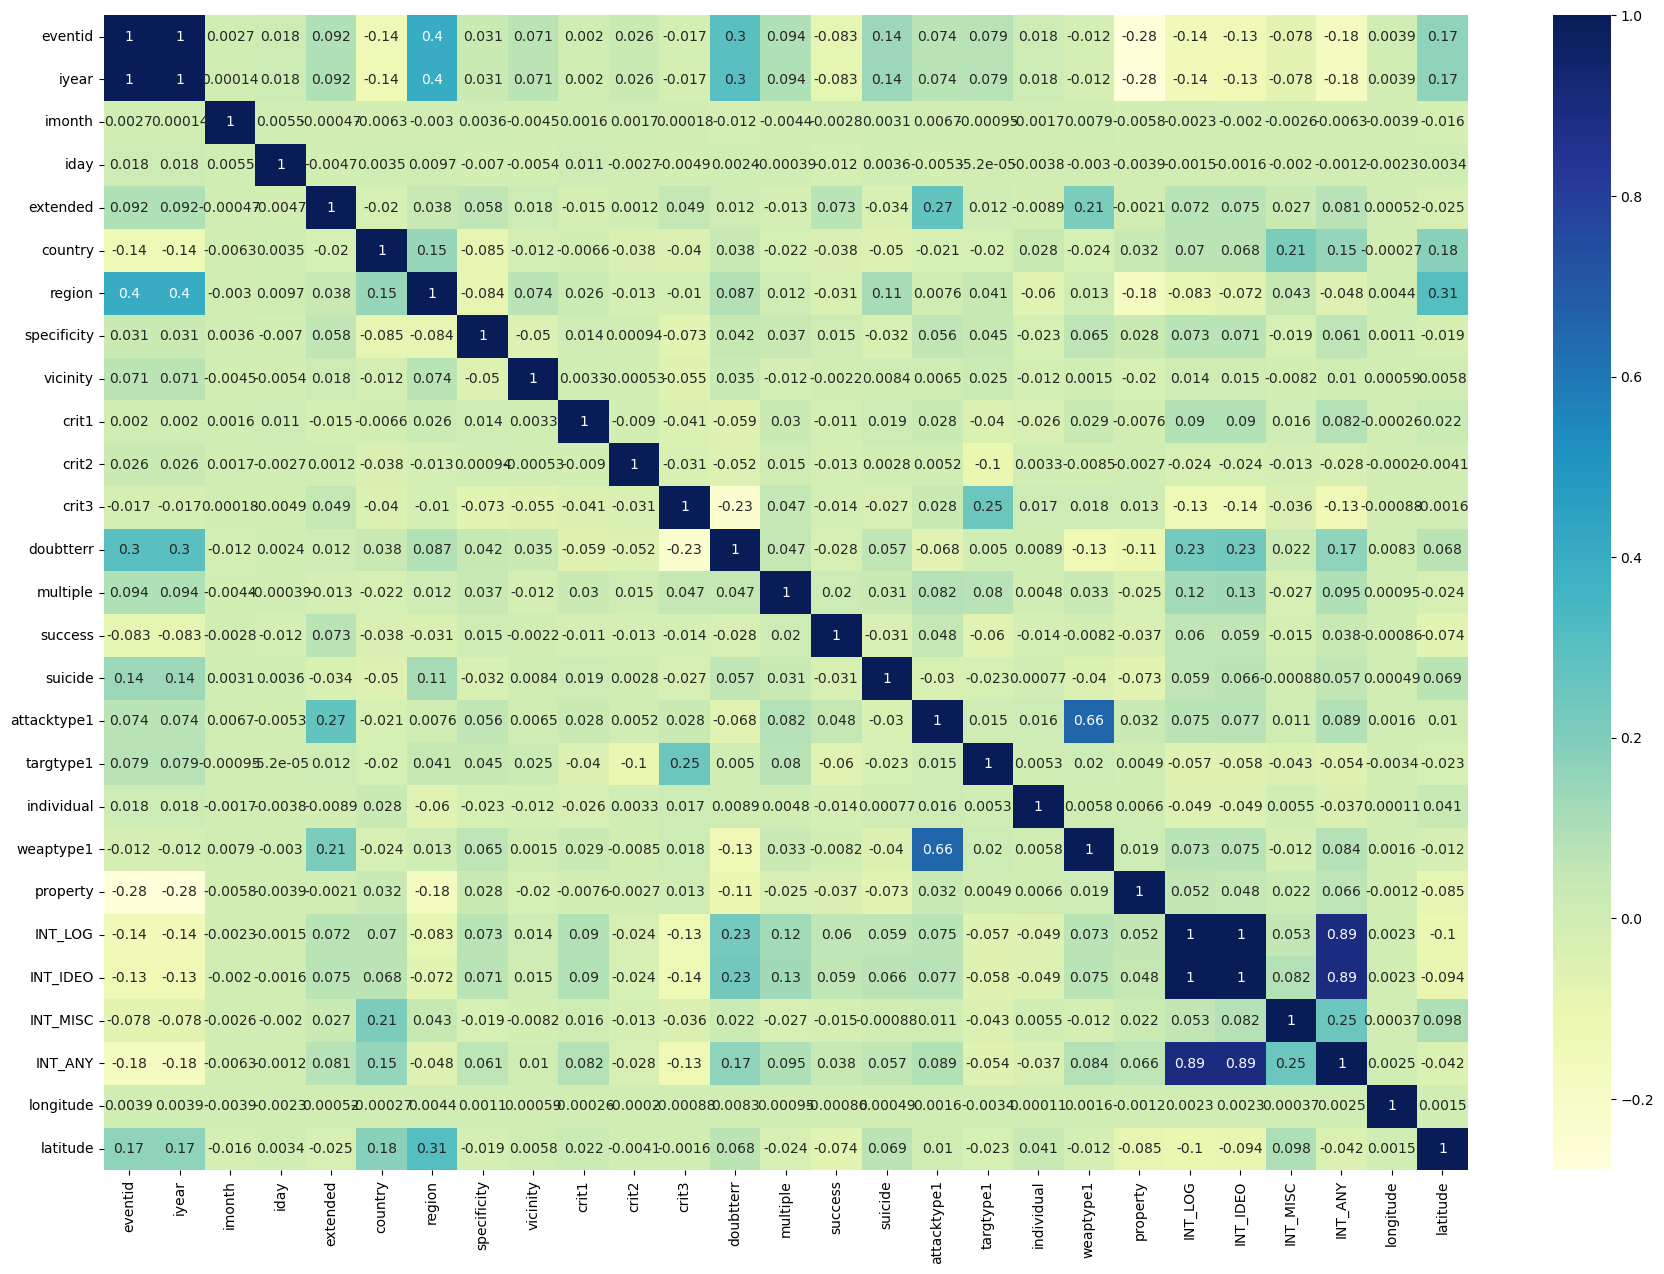

In [15]:
plt.figure(figsize=(22, 15)) 
dataplot = sns.heatmap(df.corr(),
                       cmap="YlGnBu", annot=True)

- Most correclated features are:
- **Weapon type and attacktype**
- **Int_ANT and INT_LOG and INT_IDEO**

In [16]:
column_distribution(df,'weaptype1')

,weaptype1,Count,Freq %
0,6,"92,426",50.87%
1,5,"58,524",32.21%
2,13,"15,157",8.34%
3,8,"11,135",6.13%
4,9,"3,655",2.01%
5,2,321,0.18%
6,11,141,0.08%
7,10,136,0.07%
8,12,114,0.06%
9,1,35,0.02%


In [17]:
column_distribution(df,'attacktype1')

,attacktype1,Count,Freq %
0,3,"88,255",48.57%
1,2,"42,669",23.48%
2,1,"19,312",10.63%
3,6,"11,158",6.14%
4,7,"10,356",5.70%
5,9,"7,276",4.00%
6,8,"1,015",0.56%
7,5,991,0.55%
8,4,659,0.36%


In [18]:
column_distribution(df[df.success==1],['region_txt'])

,region_txt,Count,Freq %
0,Middle East & North Africa,"44,319",27.42%
1,South Asia,"39,369",24.36%
2,South America,"17,620",10.90%
3,Sub-Saharan Africa,"16,277",10.07%
4,Western Europe,"14,161",8.76%
5,Southeast Asia,"11,151",6.90%
6,Central America & Caribbean,"9,979",6.17%
7,Eastern Europe,"4,437",2.75%
8,North America,"2,894",1.79%
9,East Asia,680,0.42%


In [19]:
column_distribution(df[df.success==1],['country_txt'])

,country_txt,Count,Freq %
0,Iraq,"21,861",13.53%
1,Pakistan,"12,600",7.79%
2,Afghanistan,"11,141",6.89%
3,India,"10,280",6.36%
4,Colombia,"7,712",4.77%
...,...,...,...
197,Gambia,1,0.00%
198,North Korea,1,0.00%
199,Andorra,1,0.00%
200,New Hebrides,1,0.00%


###  Can you spot any irregularities or outliers?

In [20]:
column_distribution(df,'vicinity')

,vicinity,Count,Freq %
0,0,"168,932",92.98%
1,1,"12,724",7.00%
2,-9,35,0.02%


In [21]:
column_distribution(df,'individual')

,individual,Count,Freq %
0,0,"181,155",99.70%
1,1,536,0.29%


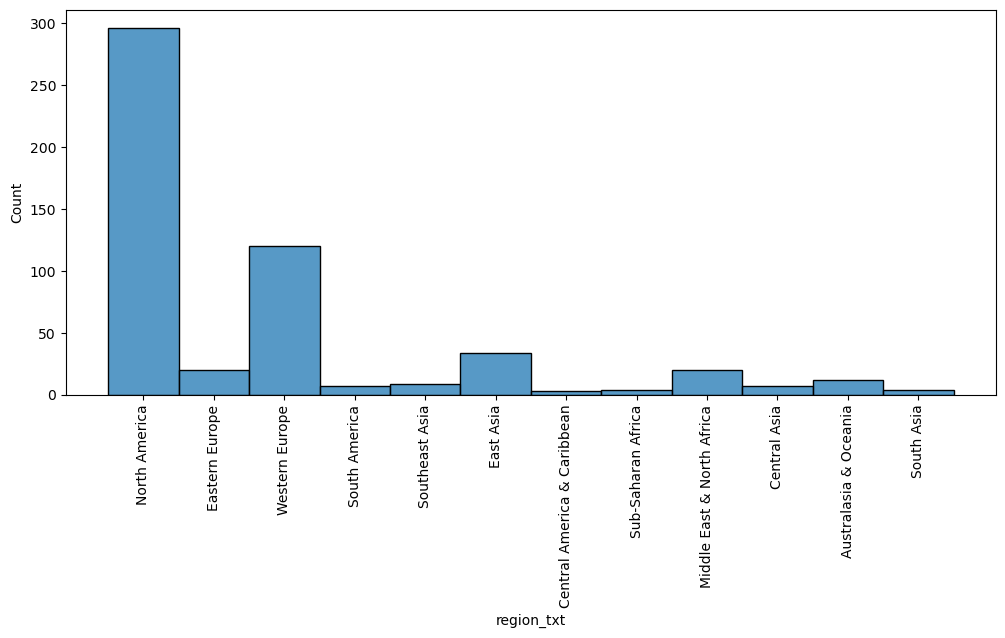

In [22]:
plt.figure(figsize=(12, 5)) 
sns.histplot(df[df.individual==1]['region_txt'])
plt.xticks(rotation=90)
plt.show()

 ## What are the most common methods of attacks? Does it differ in various regions or in time?

In [23]:
column_distribution(df,'attacktype1_txt')

,attacktype1_txt,Count,Freq %
0,Bombing/Explosion,"88,255",48.57%
1,Armed Assault,"42,669",23.48%
2,Assassination,"19,312",10.63%
3,Hostage Taking (Kidnapping),"11,158",6.14%
4,Facility/Infrastructure Attack,"10,356",5.70%
5,Unknown,"7,276",4.00%
6,Unarmed Assault,"1,015",0.56%
7,Hostage Taking (Barricade Incident),991,0.55%
8,Hijacking,659,0.36%


In [24]:
for i in df.region_txt.unique():
    print(i)
    print(column_distribution(df[df.region_txt==i],'attacktype1_txt'))
    print('')

Central America & Caribbean
                       attacktype1_txt  Count  Freq %
0                        Armed Assault  4,361  42.16%
1                    Bombing/Explosion  3,239  31.31%
2                        Assassination  1,254  12.12%
3          Hostage Taking (Kidnapping)    501   4.84%
4       Facility/Infrastructure Attack    403   3.90%
5                              Unknown    354   3.42%
6  Hostage Taking (Barricade Incident)    187   1.81%
7                            Hijacking     26   0.25%
8                      Unarmed Assault     19   0.18%

North America
                       attacktype1_txt  Count  Freq %
0                    Bombing/Explosion  1,534  44.39%
1       Facility/Infrastructure Attack    906  26.21%
2                        Armed Assault    448  12.96%
3                        Assassination    255   7.38%
4          Hostage Taking (Kidnapping)    123   3.56%
5                      Unarmed Assault     73   2.11%
6  Hostage Taking (Barricade Incident) 

- Central America & Caribbean: **Armed Assault  42%**
- North America: **Bombing/Explosion 44.39%**
- Southeast Asia: **Bombing/Explosion 38.59%**
- Western Europe: **Bombing/Explosion 51.13%**
- East Asia: **Bombing/Explosion 41.15%**
- South America: **Bombing/Explosion: 47.63%**
- Eastern Europe: **Bombing/Explosion 53.77%**
- Sub-Saharan Africa: **Armed Assault 34.21%**
- Middle East & North Africa: **Bombing/Explosion 61.23%**
- Australasia & Oceania: **Bombing/Explosion 26.60%**
- South Asia: **Bombing/Explosion: 47.24%**
- Central Asia: **Bombing/Explosion: 41.74%**

In [25]:
df1=column_distribution(df, ['region_txt','attacktype1_txt'])
df2=pd.pivot_table(df1, values='Count', index=['region_txt'],
                       columns=['attacktype1_txt'], aggfunc=np.sum)
df2

attacktype1_txt,Armed Assault,Assassination,Bombing/Explosion,Facility/Infrastructure Attack,Hijacking,Hostage Taking (Barricade Incident),Hostage Taking (Kidnapping),Unarmed Assault,Unknown
region_txt,,,,,,,,,
Australasia & Oceania,51,36,75,71,3,6,13,11,16
Central America & Caribbean,"4,361","1,254","3,239",403,26,187,501,19,354
Central Asia,116,115,235,20,8,2,45,5,17
East Asia,117,55,330,200,18,3,14,42,23
Eastern Europe,"1,274",400,"2,766",260,26,21,220,62,115
Middle East & North Africa,"9,273","4,206","30,908","1,115",138,100,"2,666",177,"1,891"
North America,448,255,"1,534",906,18,67,123,73,32
South America,"3,875","2,745","9,039",803,67,234,"1,414",47,754
South Asia,"11,404","4,301","21,246","2,189",93,120,"3,277",323,"2,021"


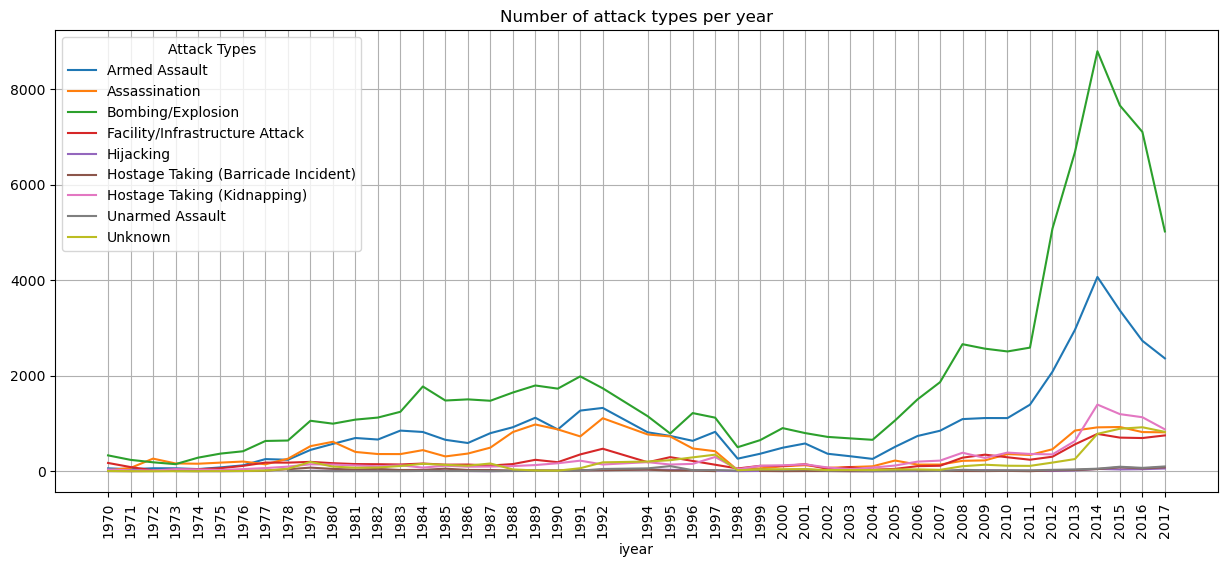

In [26]:
df1 = df.groupby(['attacktype1_txt', 'iyear']).agg({'eventid':'count'})
df1.unstack(level=0)['eventid'].plot(kind='line', figsize=(15, 6), grid=True)
plt.legend(title='Attack Types')
plt.title('Number of attack types per year')
plt.xticks([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
            1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
            1992, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
            2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
            2015, 2016, 2017],rotation=90)
plt.show()

## Plot the locations of attacks on a map to visualize their regional spread;

In [28]:
df['lat']=round(df['latitude'],2)
df['lon']=round(df['longitude'],2)
df2=df[(df['lat'].notnull())&(df['lon'].notnull())][['lon','lat']]
#df2=df1.loc[:10000]
# Create a folium map centered around the mean latitude and longitude
map_center = [df2['lat'].mean(), df2['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=2)

# Create a FastMarkerCluster layer for efficient marker clustering
marker_cluster = FastMarkerCluster(df2[['lat', 'lon']].values)
m.add_child(marker_cluster)

# Add popup information for each attack location
for index, row in df2.iterrows():
    lat = row['lat']
    lon = row['lon']
   
    folium.Marker([lat, lon]).add_to(marker_cluster)

